# Extract Data

## Setup

In [1]:
from os.path import abspath, join
from os import listdir
import glob

import ray

import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping

import re
from datetime import datetime

import rasterio, rasterio.mask
from rasterio.plot import reshape_as_image

import scipy.ndimage as ndimage
from skimage.color import rgb2gray

import skimage as ski
import mahotas

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
plt.style.use('seaborn-deep')

In [2]:
path = {'root': abspath("/mnt/hgfs/Storage/Documents/Image Classification")}

path['shapefiles'] = join(path['root'], "Shapefiles")
path['stacks'] = join(path['root'], "Stacks")
path['stats'] = join(path['root'], "Statistics")
path['data'] = join(path['root'], "Data")

In [3]:
productstacks = {
    datetime.strptime(date, "%Y%m%d").date():
    glob.glob(join(path['stacks'], date, "*.tif"))
    for date in listdir(path['stacks'])[:2]
}

productstacks

{datetime.date(2018, 9, 15): ['/mnt/hgfs/Storage/Documents/Image Classification/Stacks/20180915/R10m.tif',
  '/mnt/hgfs/Storage/Documents/Image Classification/Stacks/20180915/R20m.tif'],
 datetime.date(2018, 10, 15): ['/mnt/hgfs/Storage/Documents/Image Classification/Stacks/20181015/R10m.tif',
  '/mnt/hgfs/Storage/Documents/Image Classification/Stacks/20181015/R20m.tif']}

In [4]:
# Only *.shp files in directory
shps = glob.glob(join(path['shapefiles'], "*.shp"))
shapefile = shps[2]
print(shapefile)

shapeframe = gpd.read_file(shapefile)
shapeframe.head(1)

/mnt/hgfs/Storage/Documents/Image Classification/Shapefiles/merged_classes.shp


ID CODE_TFV    TFV TFV_G11 ESSENCE    SURF  \
0  FORESTIE0000000004523655      LA4  Lande   Lande      NC  1.2745   

  code_tfv_2     Nomenc_CES      Nom_nomenc CODE_ess  \
0        LA4  4.0.0.0.0.0.0  Lande ligneuse  4000000   

                                            geometry          area  
0  POLYGON ((480244.862 5290567.493, 480257.848 5...  12751.982793

In [5]:
flatten = lambda ll: [i for l in ll for i in l]

BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

ESS = list(shapeframe.CODE_ess.unique())
print(ESS)

['4000000', '1125000', '5000000', '1381100', '1111100', '1211000', '1114111', '1116000', '1130000', '2000000', '1213000', '1113100', '1115000', '1117000', '1225000', '1216000', '1230000', '1390000']


In [6]:
bandstatsdf = pd.read_hdf(join(path['stats'], 'bandstats.h5'), 'bandstats')
bandstatsdf.head(1)

n  min   max  auto    fd  doane  scott  rice  sturges  sqrt  \
band                                                                       
B2    31322866    0  1131  2174  2174     39    961   631       26  5597   

      blocks                                       blocks_edges  
band                                                             
B2       415  [0.0, 0.5, 10.5, 19.5, 26.5, 28.0, 29.5, 37.5,...

## Extract Features

### Set Columns

In [7]:
indexcols = ['id', 'date']

In [8]:
bandsedges = bandstatsdf.loc[:, 'blocks_edges']
bands = bandstatsdf.loc[:, 'blocks_edges'].index
edges = bandstatsdf.loc[:, 'blocks_edges'].values
edge_labels = lambda band, bandedges: [f'{band}_{e}' for e in bandedges[1:]]

imghistcolumns = flatten([edge_labels(b, e) for b, e in zip(bands, edges)])

imghistbounds = np.cumsum(bandstatsdf.loc[:, 'blocks']).values
imghistbounds = [np.insert(imghistbounds[:-1], 0, 0), imghistbounds]
bandstatsdf['bounds'] = list(zip(*imghistbounds))
bandstatsdf.head(1)

n  min   max  auto    fd  doane  scott  rice  sturges  sqrt  \
band                                                                       
B2    31322866    0  1131  2174  2174     39    961   631       26  5597   

      blocks                                       blocks_edges    bounds  
band                                                                       
B2       415  [0.0, 0.5, 10.5, 19.5, 26.5, 28.0, 29.5, 37.5,...  (0, 415)

In [9]:
glcmbound = len(imghistcolumns)
glcmcount = 13
glcmcolumns = ['GLCM_' + str(f) for f in range(glcmcount)]

In [10]:
lbpbound = glcmbound + glcmcount
lbpcount = 4
lbpcolumns = ['LBP_' + str(f) for f in range(lbpcount)]

In [11]:
featurecolumns = imghistcolumns + glcmcolumns# + lbpcolumns
columns = indexcols + featurecolumns + ['ess']

### Compute Feature Functions

In [12]:
# Bands representing BGR (in that order), used to produce gray-scale image
colorbands = ['B2', 'B3', 'B4']

# Normalisation Functions
zscalenorm = lambda x: (x - np.mean(x)) / (np.std(x))
minmaxnorm = lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x))


# Process mask before feature extraction
def process_mask(out_image):

    # Erode Masked Image by 1
    for b, band in enumerate(out_image):
        erosion = ndimage.binary_erosion(band)
        out_image[b][erosion == False] = 0

    # Crop Image by 1
    out_image = out_image[:, 1:-1, 1:-1]

    return out_image


# Erode Mask and Return Mask Pixel Values
def get_mask_pixels(out_image):

    # Remove Nomask Pixels
    out_image = np.array([band[band != -1] for band in out_image])

    return out_image


# Convert 3 Bands, in the form of BGR, from Product to Grayscale (0-255) image
def band_bgr2gray(out_image):

    # Set Nodata to 0.0 (Black)
    out_image[out_image < 0.0] = 0.0

    # Normalize Band Max to 255
    out_image = np.array([
        band / (bandstatsdf.loc[BANDS[i], 'max'] / 255.0)
        for i, band in enumerate(out_image)
    ])

    # Convert from (Band, Row, Col) to (Row, Col, Band)
    out_image = reshape_as_image(out_image)

    # Convert from BGR to RGB
    out_image = out_image[:, :, ::-1]

    # Grayscale from RGB
    gray_image = rgb2gray(out_image)

    return gray_image


# Compute the Haralick GLCM Texture Feature Vector
def get_mask_glcm(gray_image):
    # 14 Feature as described here
    ## http://murphylab.web.cmu.edu/publications/boland/boland_node26.html

    # As provided by mahotas.features.haralick
    ## https://mahotas.readthedocs.io/en/latest/api.html?#mahotas.features.haralick

    return mahotas.features.haralick(gray_image).mean(axis=0)


# Compute the Local Binary Patterns
def get_mask_lbp(gray_image, radius=3, r_points=8):
    n_points = radius * r_points

    lbp = ski.feature.local_binary_pattern(gray_image,
                                       radius,
                                       n_points,
                                       method="uniform")

    #     n_bins = int(lbp.max() + 1)
    n_bins = lbpcount

    hist, edges = np.histogram(lbp.ravel(),
                               bins=n_bins,
                               range=(0, n_bins),
                               density=True)
    return hist

### Compute Features from Stacks

In [13]:
def process_stack(stack, date, features, i=10):
    with rasterio.open(stack) as stk:
        stkbands = list(stk.descriptions)
        stkbounds = bandstatsdf.loc[list(stkbands), 'bounds']
        bandbounds = list(zip(stkbands, stkbounds))

        for num, row in shapeframe.iterrows():
            out_image, out_transform = rasterio.mask.mask(
                stk, [mapping(row['geometry'])],
                crop=True,
                all_touched=True,
                nodata=-1)

            # Both Height and Width must be larger than 2 pixels, else all mask is eroded
            if min(out_image[0].shape) > 2:

                # Process Image
                out_image = process_mask(out_image)

                # Extract Pixels
                pixels = get_mask_pixels(out_image)

                # Store Mask Color Histogram
                for (band, (lb, ub)), px in zip(bandbounds, pixels):
                    hist, _ = np.histogram(
                        px,
                        bins=bandstatsdf.loc[band, 'blocks_edges'],
                        density=True)
                    features[num, lb:ub] = hist

                # If All Color Bands in Stack Get Texture Features
                if np.equal.reduce([b in stkbands for b in colorbands]):
                    # NOTE: Assumes First 3 Bands are BGR at this point
                    gray_image = band_bgr2gray(out_image[:3])

                    # Extract LBP Features
#                     lb, ub = lbpbound, lbpbound + lbpcount
#                     features[num, lb:ub] = get_mask_lbp(gray_image)

                    # More than 1 pixel for GLCM to calculate correlation
                    if min(gray_image.shape) > 1:
                        # Typecast from float to int for mahotas GLCM
                        gray_image = np.int_(np.round(gray_image))

                        # Extract GLCM Features
                        lb, ub = glcmbound, glcmbound + glcmcount
                        features[num, lb:ub] = get_mask_glcm(gray_image)

#             i -= 1
#             if i == 0:
#                 break

    return features

In [14]:
@ray.remote
def extract_product_features(date, productstack):

    count = len(shapeframe)
    features = np.full([count, len(featurecolumns)], np.nan, dtype=np.float32)

    for stack in productstack:
        features = process_stack(stack, date, features, i=count)

    data = {}
    data[indexcols[0]] = np.array(shapeframe.ID)
    data[indexcols[1]] = np.array([date] * count, dtype='datetime64[D]')
    data['ess'] = np.array(shapeframe.CODE_ess)

    for col, feature in zip(featurecolumns, features.T):
        data[col] = feature

    df = pd.DataFrame(data, columns=columns)  #.set_index(indexcols)
    data = None

    # Normalise Columns
    for fnorm, normcols in normalise.items():
        df[normcols] = df[normcols].apply(fnorm)

    df.to_parquet(join(path['data'], f'{str(date)}.parq'), index=False)
    return df.info()

In [15]:
# Choose which columns to normalise, with the key acting as the scaler function
normalise = {
    # zscalenorm: ['GLCM_' + str(f) for f in []],
    minmaxnorm: glcmcolumns
}

ray.init()
try:
    
    df_infos = [
        extract_product_features.remote(date, productstack)
        for date, productstack in productstacks.items()
    ]

    ray.get(df_infos)

finally:
    ray.shutdown()
    
df_infos

2020-06-10 21:51:20,879	INFO resource_spec.py:212 -- Starting Ray with 7.67 GiB memory available for workers and up to 3.85 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-10 21:51:21,616	INFO services.py:1170 -- View the Ray dashboard at localhost:8265
2020-06-10 21:51:30,262	WARNING worker.py:1090 -- Warning: The remote function __main__.extract_product_features has size 41931136 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-06-10 21:51:44,142	WARNING worker.py:1090 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.
2020-06-10 21:51:44,307	WARNING worker.py:1090 -- This worker was asked to execute a function that it does not have registered. You may have to restart Ray.


(pid=106407) <class 'pandas.core.frame.DataFrame'>
(pid=106407) RangeIndex: 17918 entries, 0 to 17917
(pid=106407) Columns: 5996 entries, id to ess
(pid=106407) dtypes: datetime64[ns](1), float32(5993), object(2)
(pid=106407) memory usage: 410.0+ MB


[ObjectID(45b95b1c8bd3a9c4ffffffff010000c801000000),
 ObjectID(ef0a6c221819881cffffffff010000c801000000)]

In [15]:
date = '2018-09-15'

# pd.read_parquet(join(path['data'], f'{date}.parq'))

pq.read_table(join(path['data'], f'{date}.parq')).to_pandas()

id       date  B2_0.5  B2_10.5  B2_19.5  B2_26.5  \
0      FORESTIE0000000004523655 2018-09-15     0.0      0.0      0.0      0.0   
1      FORESTIE0000000004500002 2018-09-15     0.0      0.0      0.0      0.0   
2      FORESTIE0000000004523656 2018-09-15     0.0      0.0      0.0      0.0   
3      FORESTIE0000000004500004 2018-09-15     0.0      0.0      0.0      0.0   
4      FORESTIE0000000004523658 2018-09-15     0.0      0.0      0.0      0.0   
...                         ...        ...     ...      ...      ...      ...   
17913  FORESTIE0000000008908466 2018-09-15     0.0      0.0      0.0      0.0   
17914  FORESTIE0000000008908472 2018-09-15     0.0      0.0      0.0      0.0   
17915  FORESTIE0000000008908473 2018-09-15     0.0      0.0      0.0      0.0   
17916  FORESTIE0000000008908474 2018-09-15     0.0      0.0      0.0      0.0   
17917  FORESTIE0000000008908480 2018-09-15     0.0      0.0      0.0      0.0   

       B2_28.0  B2_29.5  B2_37.5  B2_43.5  ...    GLCM_4    GLCM_5    GLCM_6  \
0          0.0      0.0      0.0      0.0  ... -0.323149  0.149184 -0.039227   
1          0.0      0.0      0.0      0.0  ...  0.194314 -0.051025  0.047552   
2          0.0      0.0      0.0      0.0  ... -0.223348  0.135463  0.029683   
3          0.0      0.0      0.0      0.0  ... -0.230113  0.128074 -0.021255   
4          0.0      0.0      0.0      0.0  ...  0.024141  0.033856  0.046777   
...        ...      ...      ...      ...  ...       ...       ...       ...   
17913      0.0      0.0      0.0      0.0  ... -0.088092  0.034771  0.039505   
17914      0.0      0.0      0.0      0.0  ...  0.043064 -0.043276 -0.015686   
17915      0.0      0.0      0.0      0.0  ... -0.080628 -0.017171 -0.029990   
17916      0.0      0.0      0.0      0.0  ...  0.017856  0.009180  0.043833   
17917      0.0      0.0      0.0      0.0  ... -0.275497  0.263514  0.179353   

         GLCM_7    GLCM_8    GLCM_9   GLCM_10   GLCM_11   GLCM_12      ess  
0      0.173408  0.148413 -0.077144  0.175411 -0.185205  0.045077  4000000  
1     -0.131104 -0.182403  0.030083 -0.080594 -0.129336  0.025521  1125000  
2      0.112909  0.051197 -0.073048  0.172626 -0.181925  0.043998  4000000  
3      0.191531  0.193792 -0.081365  0.198362 -0.070926  0.042993  1125000  
4      0.029476  0.006367 -0.012223  0.015448  0.007052  0.024278  4000000  
...         ...       ...       ...       ...       ...       ...      ...  
17913  0.129208  0.100214 -0.062025  0.134760 -0.097369  0.042165  1114111  
17914  0.014729  0.051337  0.003969  0.007260  0.148253 -0.019603  1114111  
17915  0.065222  0.050621 -0.023459  0.056102 -0.027186  0.034313  1114111  
17916  0.096435  0.110594 -0.040020  0.089485  0.021886  0.031971  1114111  
17917  0.178649  0.093424 -0.092722  0.318227 -0.292601  0.045613  1130000  

[17918 rows x 5996 columns]

### Normalisation Comparison

In [188]:
shapefeatures[glcmcolumns] = shapefeatures[glcmcolumns].apply(minmaxnorm)

In [190]:
# shapefeatures[glcmcolumns].hist(figsize=fs)
shapefeatures[glcmcolumns+lbpcolumns].describe()

GLCM_0        GLCM_1        GLCM_2        GLCM_3        GLCM_4  \
count  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04   
mean   1.172578e-17 -4.769810e-18  3.279245e-17 -5.962263e-18 -4.610817e-17   
std    1.455427e-01  6.811166e-02  1.311549e-01  6.729100e-02  1.803875e-01   
min   -1.479869e-01 -7.453023e-02 -7.657028e-01 -8.359344e-02 -4.137437e-01   
25%   -1.140168e-01 -4.706273e-02 -7.547431e-02 -3.926011e-02 -1.418899e-01   
50%   -4.527341e-02 -1.984064e-02  2.201625e-02 -1.671257e-02 -3.100269e-03   
75%    6.982004e-02  2.351993e-02  1.013535e-01  1.731443e-02  1.312242e-01   
max    8.520131e-01  9.254698e-01  2.342972e-01  9.164066e-01  5.862563e-01   

             GLCM_5        GLCM_6        GLCM_7        GLCM_8        GLCM_9  \
count  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04   
mean   1.192453e-18 -3.974842e-18 -3.577358e-18  2.692955e-17  1.192453e-17   
std    8.761661e-02  6.629205e-02  1.225163e-01  1.292377e-01  8.585445e-02   
min   -1.755113e-01 -7.928935e-02 -6.075714e-01 -6.361395e-01 -9.494474e-02   
25%   -6.039963e-02 -3.594444e-02 -6.932516e-02 -6.885020e-02 -6.136816e-02   
50%   -1.554676e-02 -1.569344e-02  2.327559e-02  1.925793e-02 -2.533779e-02   
75%    4.387640e-02  1.496961e-02  8.651378e-02  8.614161e-02  3.566904e-02   
max    8.244887e-01  9.207106e-01  3.924286e-01  3.638605e-01  9.050553e-01   

            GLCM_10       GLCM_11       GLCM_12         LBP_0         LBP_1  \
count  1.787600e+04  1.787600e+04  1.787600e+04  17891.000000  17891.000000   
mean   7.273961e-17  1.112956e-17  5.048049e-17      0.578372      0.044689   
std    1.451246e-01  1.362821e-01  5.742415e-02      0.211460      0.068816   
min   -6.486002e-01 -5.452511e-01 -9.541743e-01      0.047397      0.000000   
25%   -9.609409e-02 -1.067280e-01 -2.189068e-02      0.413462      0.000000   
50%    2.023353e-02  7.243246e-03  2.425834e-02      0.591880      0.000000   
75%    1.122802e-01  1.093178e-01  4.006269e-02      0.740741      0.072812   
max    3.513998e-01  4.547489e-01  4.582570e-02      1.000000      0.429321   

              LBP_2         LBP_3  
count  17891.000000  17891.000000  
mean       0.005382      0.371558  
std        0.017259      0.174235  
min        0.000000      0.000000  
25%        0.000000      0.248257  
50%        0.000000      0.370476  
75%        0.000000      0.493171  
max        0.166022      0.944513

GLCM_0        GLCM_1        GLCM_2        GLCM_3        GLCM_4  \
count  17876.000000  17876.000000  17876.000000  17876.000000  17876.000000   
mean       0.131818    952.975212      0.640132   1321.778138      0.395439   
std        0.127628    865.235058      0.179134   1060.108084      0.168767   
min        0.002046      6.203941     -0.405682      4.840041      0.008349   
25%        0.031835    355.128650      0.537047    703.271070      0.262690   
50%        0.092117    700.935840      0.670202   1058.486824      0.392539   
75%        0.193044   1251.753246      0.778563   1594.551132      0.518210   
max        0.878960  12709.388889      0.960140  15758.924858      0.943929   

             GLCM_5        GLCM_6        GLCM_7        GLCM_8        GLCM_9  \
count  17876.000000  17876.000000  17876.000000  17876.000000  17876.000000   
mean      89.807277   4334.137340      4.978970      6.477495      0.001158   
std       40.917060   3612.675426      0.843421      1.112909      0.000973   
min        7.843312     13.156222      0.796353      0.999486      0.000081   
25%       61.600578   2375.296111      4.501725      5.884603      0.000462   
50%       82.546922   3478.902204      5.139203      6.643332      0.000870   
75%      110.297606   5149.926876      5.574545      7.219290      0.001562   
max      474.844491  54509.516927      7.680510      9.610820      0.011419   

            GLCM_10       GLCM_11       GLCM_12  
count  17876.000000  17876.000000  17876.000000  
mean       3.995041     -0.483782      0.981328  
std        0.746014      0.116528      0.023371  
min        0.660906     -0.950000      0.592983  
25%        3.501068     -0.575040      0.972418  
50%        4.099051     -0.477589      0.991201  
75%        4.572218     -0.390310      0.997633  
max        5.801414     -0.094948      0.999979

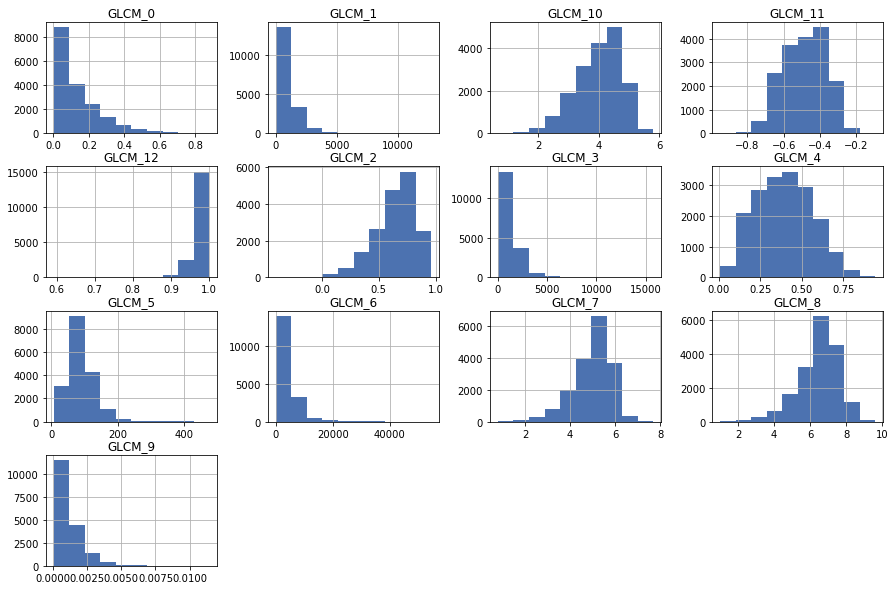

In [186]:
fs = (15, 10)
# shapefeatures[glcmcolumns].plot(figsize=fs)
shapefeatures[glcmcolumns].hist(figsize=fs)
shapefeatures[glcmcolumns].describe()

GLCM_0        GLCM_1        GLCM_2        GLCM_3        GLCM_4  \
count  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04   
mean   1.172578e-17 -4.769810e-18  3.279245e-17 -5.962263e-18 -4.610817e-17   
std    1.455427e-01  6.811166e-02  1.311549e-01  6.729100e-02  1.803875e-01   
min   -1.479869e-01 -7.453023e-02 -7.657028e-01 -8.359344e-02 -4.137437e-01   
25%   -1.140168e-01 -4.706273e-02 -7.547431e-02 -3.926011e-02 -1.418899e-01   
50%   -4.527341e-02 -1.984064e-02  2.201625e-02 -1.671257e-02 -3.100269e-03   
75%    6.982004e-02  2.351993e-02  1.013535e-01  1.731443e-02  1.312242e-01   
max    8.520131e-01  9.254698e-01  2.342972e-01  9.164066e-01  5.862563e-01   

             GLCM_5        GLCM_6        GLCM_7        GLCM_8        GLCM_9  \
count  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04   
mean   1.192453e-18 -3.974842e-18 -3.577358e-18  2.692955e-17  1.192453e-17   
std    8.761661e-02  6.629205e-02  1.225163e-01  1.292377e-01  8.585445e-02   
min   -1.755113e-01 -7.928935e-02 -6.075714e-01 -6.361395e-01 -9.494474e-02   
25%   -6.039963e-02 -3.594444e-02 -6.932516e-02 -6.885020e-02 -6.136816e-02   
50%   -1.554676e-02 -1.569344e-02  2.327559e-02  1.925793e-02 -2.533779e-02   
75%    4.387640e-02  1.496961e-02  8.651378e-02  8.614161e-02  3.566904e-02   
max    8.244887e-01  9.207106e-01  3.924286e-01  3.638605e-01  9.050553e-01   

            GLCM_10       GLCM_11       GLCM_12  
count  1.787600e+04  1.787600e+04  1.787600e+04  
mean   7.273961e-17  1.112956e-17  5.048049e-17  
std    1.451246e-01  1.362821e-01  5.742415e-02  
min   -6.486002e-01 -5.452511e-01 -9.541743e-01  
25%   -9.609409e-02 -1.067280e-01 -2.189068e-02  
50%    2.023353e-02  7.243246e-03  2.425834e-02  
75%    1.122802e-01  1.093178e-01  4.006269e-02  
max    3.513998e-01  4.547489e-01  4.582570e-02

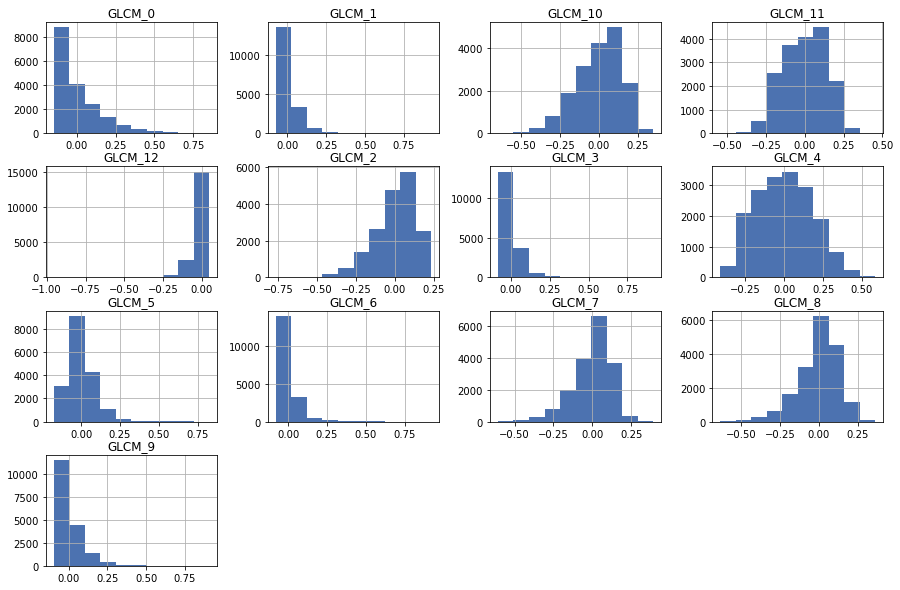

In [183]:
minmaxglcm = shapefeatures[glcmcolumns].apply(minmaxnorm)
# minmaxglcm.plot(figsize=fs)
minmaxglcm.hist(figsize=fs)
minmaxglcm.describe()

GLCM_0        GLCM_1        GLCM_2        GLCM_3        GLCM_4  \
count  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04   
mean   6.598238e-17 -9.539621e-17  2.289509e-16 -7.631696e-17 -2.289509e-16   
std    1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00   
min   -1.016822e+00 -1.094267e+00 -5.838319e+00 -1.242303e+00 -2.293702e+00   
25%   -7.834123e-01 -6.909837e-01 -5.754754e-01 -5.834541e-01 -7.866059e-01   
50%   -3.110748e-01 -2.913040e-01  1.678692e-01 -2.483697e-01 -1.718720e-02   
75%    4.797354e-01  3.453240e-01  7.727986e-01  2.573140e-01  7.274775e-01   
max    5.854205e+00  1.358792e+01  1.786466e+00  1.361894e+01  3.250073e+00   

             GLCM_5        GLCM_6        GLCM_7        GLCM_8        GLCM_9  \
count  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04  1.787600e+04   
mean   1.907924e-17 -3.815848e-17 -9.539621e-18  2.075861e-16  1.303748e-16   
std    1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00  1.000028e+00   
min   -2.003229e+00 -1.196095e+00 -4.959246e+00 -4.922381e+00 -1.105911e+00   
25%   -6.893821e-01 -5.422286e-01 -5.658603e-01 -5.327556e-01 -7.148130e-01   
50%   -1.774457e-01 -2.367384e-01  1.899849e-01  1.490158e-01 -2.951333e-01   
75%    5.007912e-01  2.258194e-01  7.061608e-01  6.665548e-01  4.154710e-01   
max    9.410451e+00  1.388909e+01  3.203162e+00  2.815515e+00  1.054204e+01   

            GLCM_10       GLCM_11       GLCM_12  
count  1.787600e+04  1.787600e+04  1.787600e+04  
mean   5.119596e-16  6.359747e-17  8.871847e-16  
std    1.000028e+00  1.000028e+00  1.000028e+00  
min   -4.469388e+00 -4.001012e+00 -1.661672e+01  
25%   -6.621672e-01 -7.831622e-01 -3.812211e-01  
50%    1.394256e-01  5.315040e-02  4.224532e-01  
75%    7.737030e-01  8.021660e-01  6.976822e-01  
max    2.421433e+00  3.336914e+00  7.980437e-01

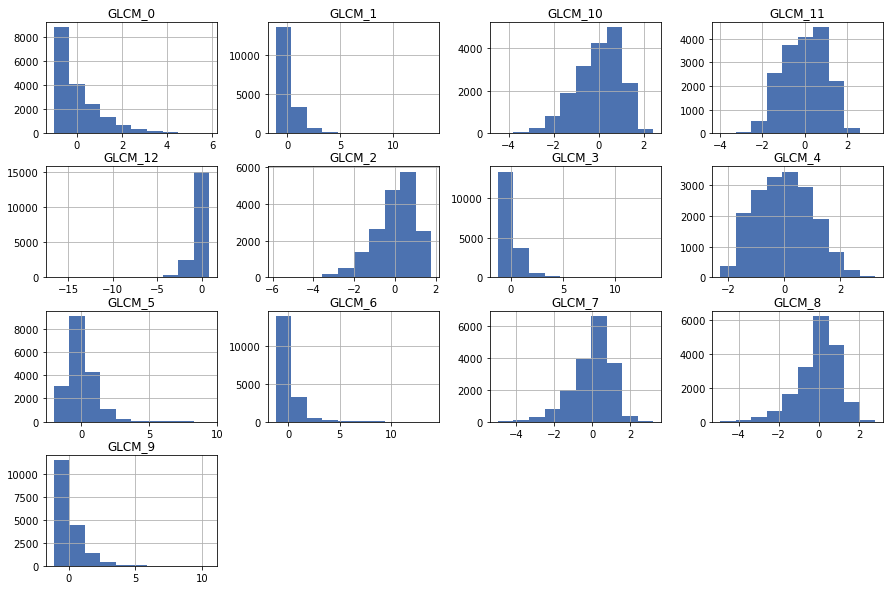

In [184]:
zscaleglcm = shapefeatures[glcmcolumns].apply(zscalenorm)
# zscaleglcm.plot(figsize=fs)
zscaleglcm.hist(figsize=fs)
zscaleglcm.describe()